In [1]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\Prashant Singh\OneDrive\Documents\Internships\Alfido Tech\Customer Behaviour_Task2\ecommerce_customer_data_custom_ratios.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Dataset Preview:")
print(data.head())

# Check for missing values and data types
print("\nSummary of Missing Values:")
print(data.isnull().sum())

print("\nData Types:")
print(data.dtypes)


Dataset Preview:
   Customer ID        Purchase Date Product Category  Product Price  Quantity  \
0        46251  2020-09-08 09:38:32      Electronics             12         3   
1        46251  2022-03-05 12:56:35             Home            468         4   
2        46251  2022-05-23 18:18:01             Home            288         2   
3        46251  2020-11-12 13:13:29         Clothing            196         1   
4        13593  2020-11-27 17:55:11             Home            449         1   

   Total Purchase Amount Payment Method  Customer Age  Returns  \
0                    740    Credit Card            37      0.0   
1                   2739         PayPal            37      0.0   
2                   3196         PayPal            37      0.0   
3                   3509         PayPal            37      0.0   
4                   3452    Credit Card            49      0.0   

         Customer Name  Age  Gender  Churn  
0  Christine Hernandez   37    Male      0  
1  Christ

In [2]:
# Handle missing values (if any)
# For this example, we'll fill missing numerical values with the mean and categorical values with the mode.
data.fillna({
    'Age': data['Age'].mean(),
    'Churn': data['Churn'].mode()[0],
    'Customer Age': data['Customer Age'].mean(),
    'Customer ID': data['Customer ID'].mode()[0],
    'Customer Name': data['Customer Name'].mode()[0],
    'Gender': data['Gender'].mode()[0],
    'Payment Method': data['Payment Method'].mode()[0],
    'Product Category': data['Product Category'].mode()[0],
    'Product Price': data['Product Price'].mean(),
    'Purchase Date': data['Purchase Date'].mode()[0],
    'Quantity': data['Quantity'].mean(),
    'Returns': data['Returns'].mean(),
    'Total Purchase Amount': data['Total Purchase Amount'].mean(),
}, inplace=True)

# Convert Purchase Date to datetime format
data['Purchase Date'] = pd.to_datetime(data['Purchase Date'])

# Re-check data types
print("\nData Types After Cleaning:")
print(data.dtypes)



Data Types After Cleaning:
Customer ID                       int64
Purchase Date            datetime64[ns]
Product Category                 object
Product Price                     int64
Quantity                          int64
Total Purchase Amount             int64
Payment Method                   object
Customer Age                      int64
Returns                         float64
Customer Name                    object
Age                               int64
Gender                           object
Churn                             int64
dtype: object


In [5]:
# Extract the month and year of the first purchase
data['OrderMonth'] = data['Purchase Date'].dt.to_period('M')
data['CohortMonth'] = data.groupby('Customer ID')['Purchase Date'].transform('min').dt.to_period('M')

# Calculate the difference in months between the order month and the cohort month
data['CohortIndex'] = (data['OrderMonth'] - data['CohortMonth']).apply(lambda x: x.n)

# Group by CohortMonth and CohortIndex to calculate retention
cohort_data = data.groupby(['CohortMonth', 'CohortIndex']).size().unstack(fill_value=0)

# Calculate retention rate
cohort_size = cohort_data.iloc[:, 0]
retention_matrix = cohort_data.divide(cohort_size, axis=0)

print("\nCohort Analysis - Retention Matrix:")
print(retention_matrix)



Cohort Analysis - Retention Matrix:
CohortIndex   0         1         2         3         4         5         6   \
CohortMonth                                                                    
2020-01      1.0  0.097239  0.107438  0.102866  0.099349  0.110955  0.107614   
2020-02      1.0  0.111960  0.107829  0.114646  0.101425  0.109895  0.105350   
2020-03      1.0  0.094260  0.109492  0.097351  0.115673  0.101104  0.104857   
2020-04      1.0  0.117781  0.106936  0.109458  0.108197  0.102648  0.112484   
2020-05      1.0  0.105177  0.105451  0.112846  0.109011  0.118872  0.109559   
2020-06      1.0  0.118056  0.101326  0.092172  0.110480  0.114268  0.110795   
2020-07      1.0  0.107692  0.103679  0.112375  0.101003  0.101672  0.111706   
2020-08      1.0  0.108501  0.111484  0.109620  0.118195  0.108501  0.095824   
2020-09      1.0  0.094102  0.102775  0.106678  0.104944  0.090199  0.110147   
2020-10      1.0  0.099600  0.122623  0.106106  0.093594  0.112112  0.103103   
202

In [6]:
import datetime as dt

# Define the analysis date (we can set it as the most recent date in the dataset)
analysis_date = data['Purchase Date'].max() + dt.timedelta(days=1)

# Calculate RFM metrics
rfm_table = data.groupby('Customer ID').agg({
    'Purchase Date': lambda x: (analysis_date - x.max()).days,
    'Customer ID': 'count',
    'Total Purchase Amount': 'sum'
})

# Rename the columns
rfm_table.rename(columns={
    'Purchase Date': 'Recency',
    'Customer ID': 'Frequency',
    'Total Purchase Amount': 'Monetary'
}, inplace=True)

print("\nRFM Table:")
print(rfm_table.head())



RFM Table:
             Recency  Frequency  Monetary
Customer ID                              
1                 58          1      3491
2                299          3      7988
3                 89          8     22587
4                127          4      8715
5                171          8     12524


In [7]:
# Define RFM segmentation
rfm_table['RFM_Segment'] = (
    pd.qcut(rfm_table['Recency'], 4, labels=range(4, 0, -1)).astype(str) +
    pd.qcut(rfm_table['Frequency'], 4, labels=range(1, 5)).astype(str) +
    pd.qcut(rfm_table['Monetary'], 4, labels=range(1, 5)).astype(str)
)

# Calculate RFM score
rfm_table['RFM_Score'] = rfm_table[['Recency', 'Frequency', 'Monetary']].rank(method='first').sum(axis=1)

print("\nCustomer Segmentation (Top 10):")
print(rfm_table.head(10))



Customer Segmentation (Top 10):
             Recency  Frequency  Monetary RFM_Segment  RFM_Score
Customer ID                                                     
1                 58          1      3491         411    11671.0
2                299          3      7988         211    50009.0
3                 89          8     22587         344   101153.0
4                127          4      8715         321    43922.0
5                171          8     12524         342    89767.0
6                463          6     15517         133   103118.0
7                566          3      7835         111    59953.0
8                130          6     15265         333    80431.0
9                127          5     14720         323    69784.0
10               230          8     20857         244   113916.0


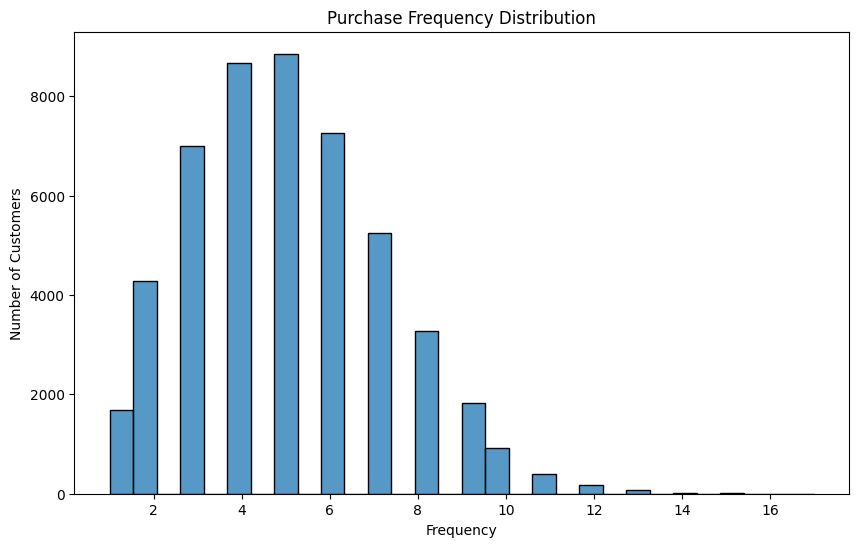

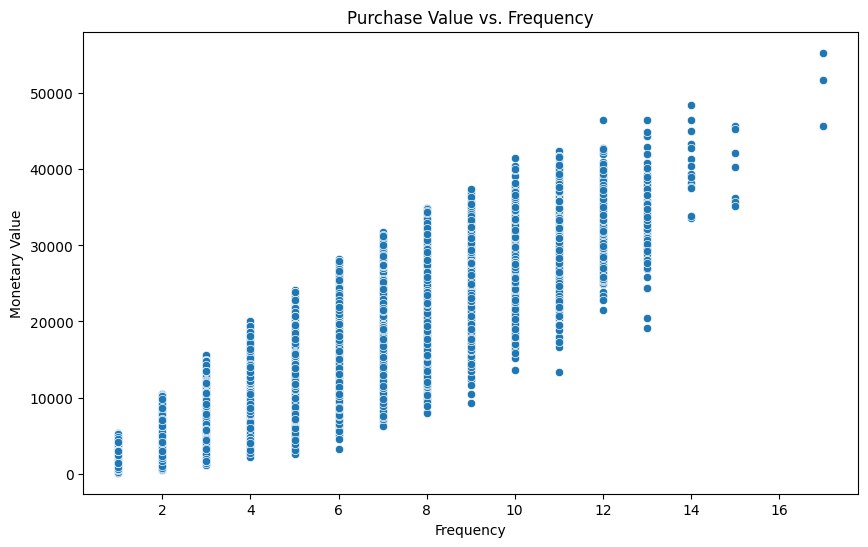

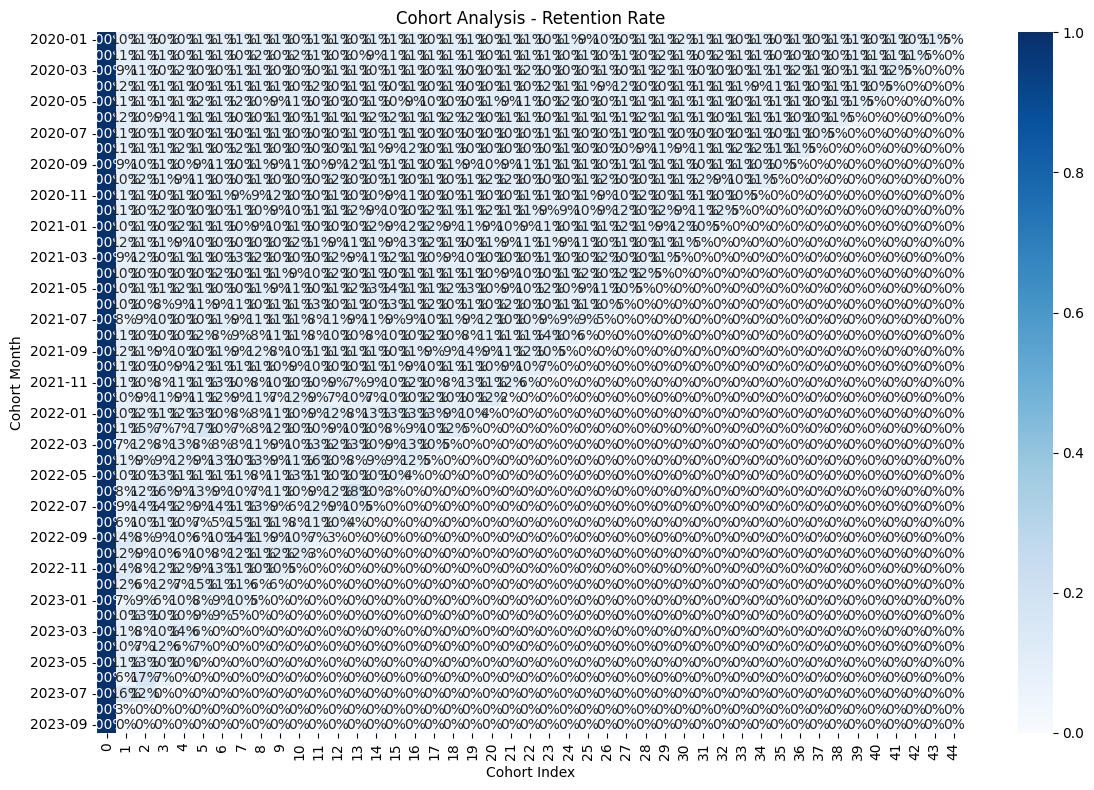

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for Purchase Frequency
plt.figure(figsize=(10, 6))
sns.histplot(rfm_table['Frequency'], kde=False, bins=30)
plt.title('Purchase Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Customers')
plt.show()

# Scatter plot for Purchase Value vs. Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', data=rfm_table)
plt.title('Purchase Value vs. Frequency')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.show()

# Heatmap for Customer Activity Patterns
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Analysis - Retention Rate')
plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')
plt.tight_layout()  # Adjust layout
plt.show()
